In [2]:
from transformers import AutoImageProcessor
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoImageProcessor

In [4]:
from huggingface_hub import notebook_login

notebook_login()

# Swin Base RAW

In [5]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/swin-base-patch4-window7-224-rawdata-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-63995c869c210857/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9326


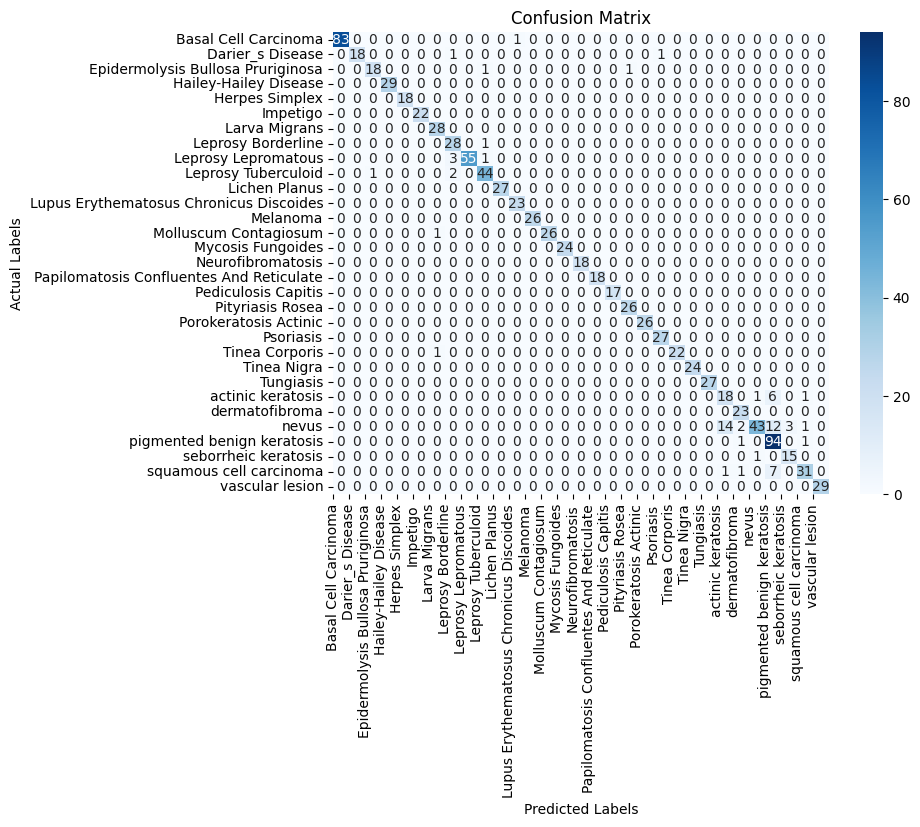

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     1.0000    0.9881    0.9940        84
                        Darier_s Disease     1.0000    0.9000    0.9474        20
       Epidermolysis Bullosa Pruriginosa     0.9474    0.9000    0.9231        20
                   Hailey-Hailey Disease     1.0000    1.0000    1.0000        29
                          Herpes Simplex     1.0000    1.0000    1.0000        18
                                Impetigo     1.0000    1.0000    1.0000        22
                           Larva Migrans     0.9333    1.0000    0.9655        28
                      Leprosy Borderline     0.8235    0.9655    0.8889        29
                     Leprosy Lepromatous     1.0000    0.9322    0.9649        59
                     Leprosy Tuberculoid     0.9362    0.9362    0.9362        47
                           Lichen Planus     1.0000    1.0000    1.0000  

In [7]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)

# Dino Base RAW

In [8]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/dinov2-base-rawdata-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)


Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9648


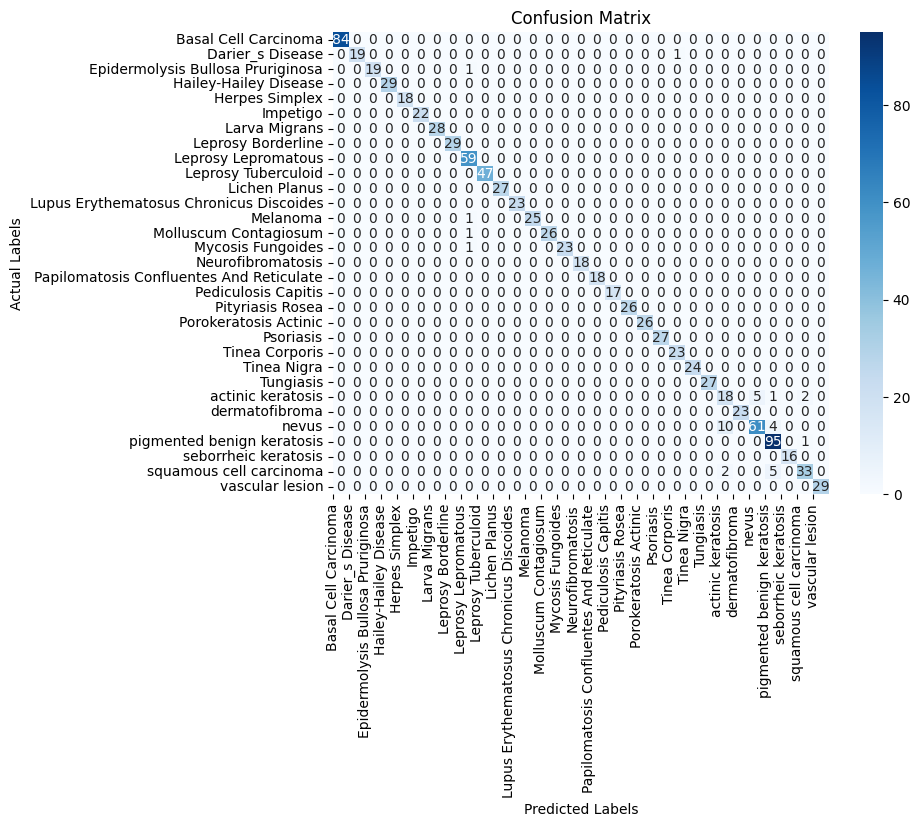

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     1.0000    1.0000    1.0000        84
                        Darier_s Disease     1.0000    0.9500    0.9744        20
       Epidermolysis Bullosa Pruriginosa     1.0000    0.9500    0.9744        20
                   Hailey-Hailey Disease     1.0000    1.0000    1.0000        29
                          Herpes Simplex     1.0000    1.0000    1.0000        18
                                Impetigo     1.0000    1.0000    1.0000        22
                           Larva Migrans     1.0000    1.0000    1.0000        28
                      Leprosy Borderline     1.0000    1.0000    1.0000        29
                     Leprosy Lepromatous     0.9365    1.0000    0.9672        59
                     Leprosy Tuberculoid     1.0000    1.0000    1.0000        47
                           Lichen Planus     1.0000    1.0000    1.0000  

In [10]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)

# VIT Base RAW

In [11]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/vit-base-patch16-224-rawdata-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)


Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9235


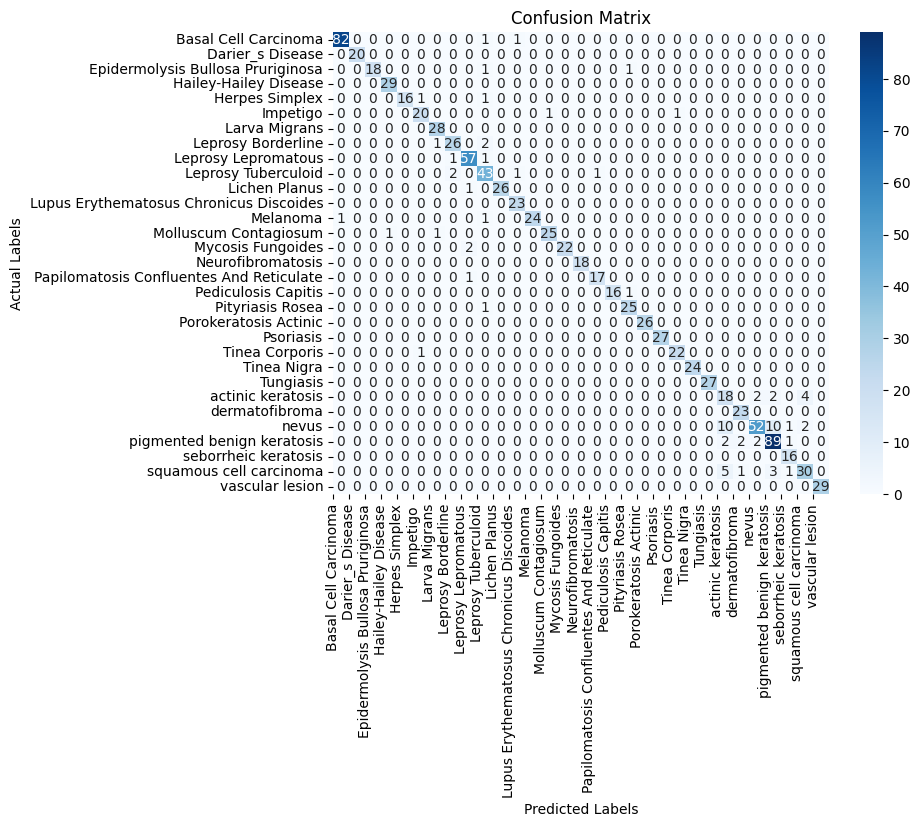

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     0.9880    0.9762    0.9820        84
                        Darier_s Disease     1.0000    1.0000    1.0000        20
       Epidermolysis Bullosa Pruriginosa     1.0000    0.9000    0.9474        20
                   Hailey-Hailey Disease     0.9667    1.0000    0.9831        29
                          Herpes Simplex     1.0000    0.8889    0.9412        18
                                Impetigo     0.9091    0.9091    0.9091        22
                           Larva Migrans     0.9333    1.0000    0.9655        28
                      Leprosy Borderline     0.8966    0.8966    0.8966        29
                     Leprosy Lepromatous     0.9344    0.9661    0.9500        59
                     Leprosy Tuberculoid     0.8431    0.9149    0.8776        47
                           Lichen Planus     1.0000    0.9630    0.9811  

In [13]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)

# Swin Base 

In [14]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/swin-base-patch4-window7-224-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9044


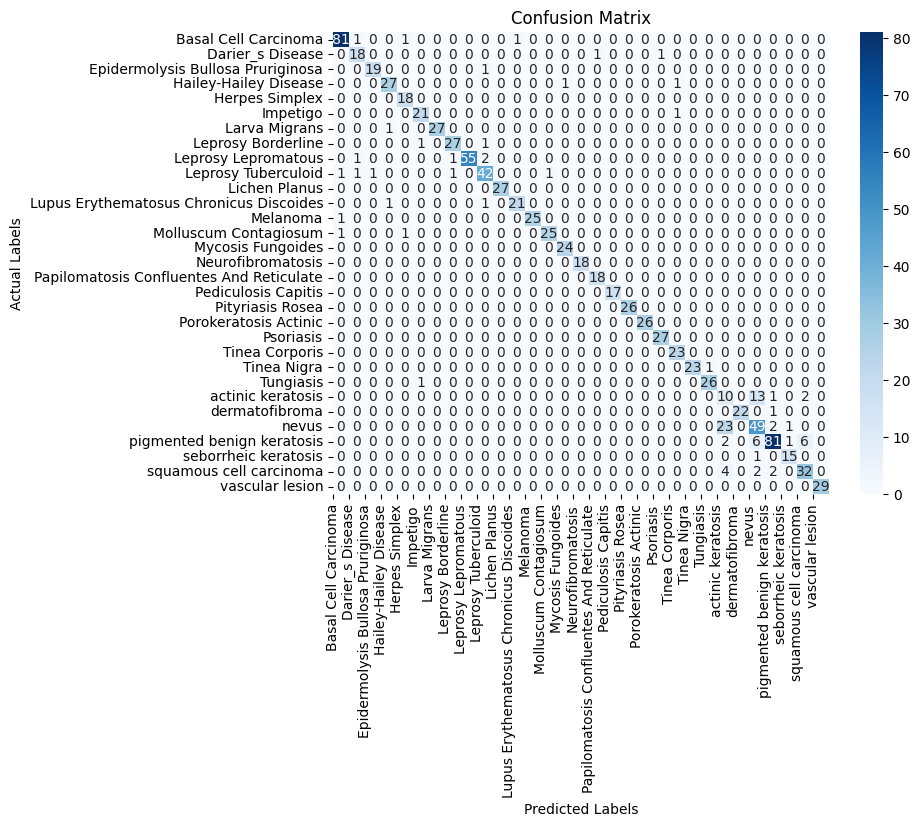

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     0.9643    0.9643    0.9643        84
                        Darier_s Disease     0.8571    0.9000    0.8780        20
       Epidermolysis Bullosa Pruriginosa     0.9500    0.9500    0.9500        20
                   Hailey-Hailey Disease     0.9310    0.9310    0.9310        29
                          Herpes Simplex     0.9000    1.0000    0.9474        18
                                Impetigo     0.9130    0.9545    0.9333        22
                           Larva Migrans     1.0000    0.9643    0.9818        28
                      Leprosy Borderline     0.9310    0.9310    0.9310        29
                     Leprosy Lepromatous     1.0000    0.9322    0.9649        59
                     Leprosy Tuberculoid     0.8936    0.8936    0.8936        47
                           Lichen Planus     1.0000    1.0000    1.0000  

In [16]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)

# Dino Base

In [17]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/dinov2-base-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9557


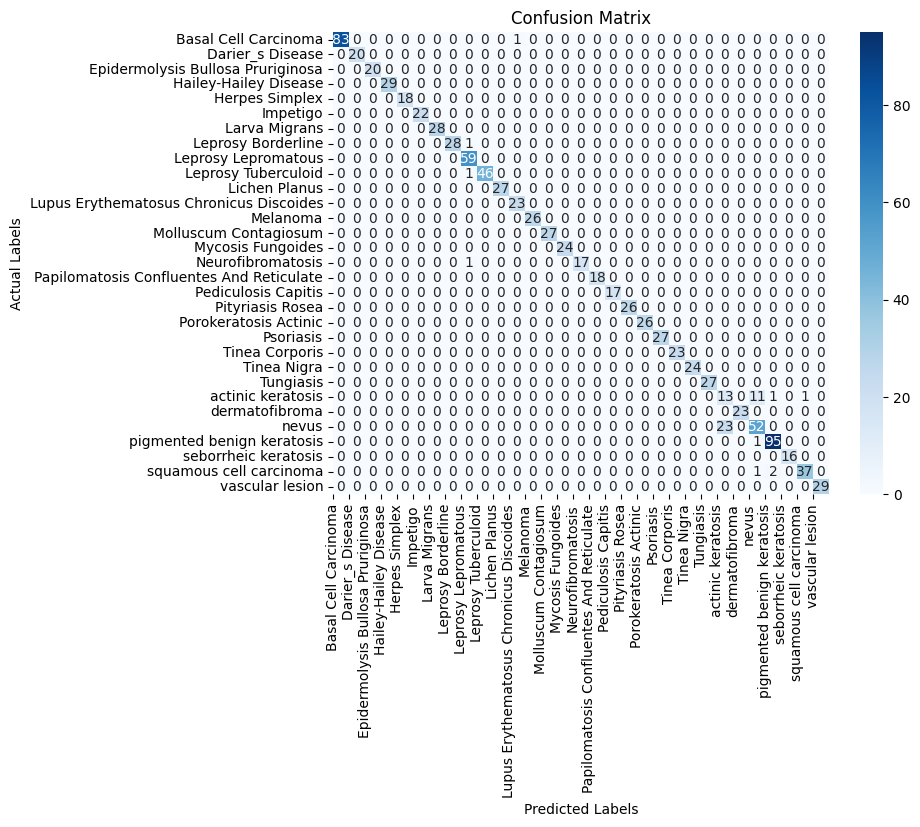

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     1.0000    0.9881    0.9940        84
                        Darier_s Disease     1.0000    1.0000    1.0000        20
       Epidermolysis Bullosa Pruriginosa     1.0000    1.0000    1.0000        20
                   Hailey-Hailey Disease     1.0000    1.0000    1.0000        29
                          Herpes Simplex     1.0000    1.0000    1.0000        18
                                Impetigo     1.0000    1.0000    1.0000        22
                           Larva Migrans     1.0000    1.0000    1.0000        28
                      Leprosy Borderline     1.0000    0.9655    0.9825        29
                     Leprosy Lepromatous     0.9516    1.0000    0.9752        59
                     Leprosy Tuberculoid     1.0000    0.9787    0.9892        47
                           Lichen Planus     1.0000    1.0000    1.0000  

In [19]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)

# VIT Base

In [20]:
# Load the pre-trained model and image processor
repo_name = "Jayanth2002/vit_base_patch16_224-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Test Accuracy: 0.9437


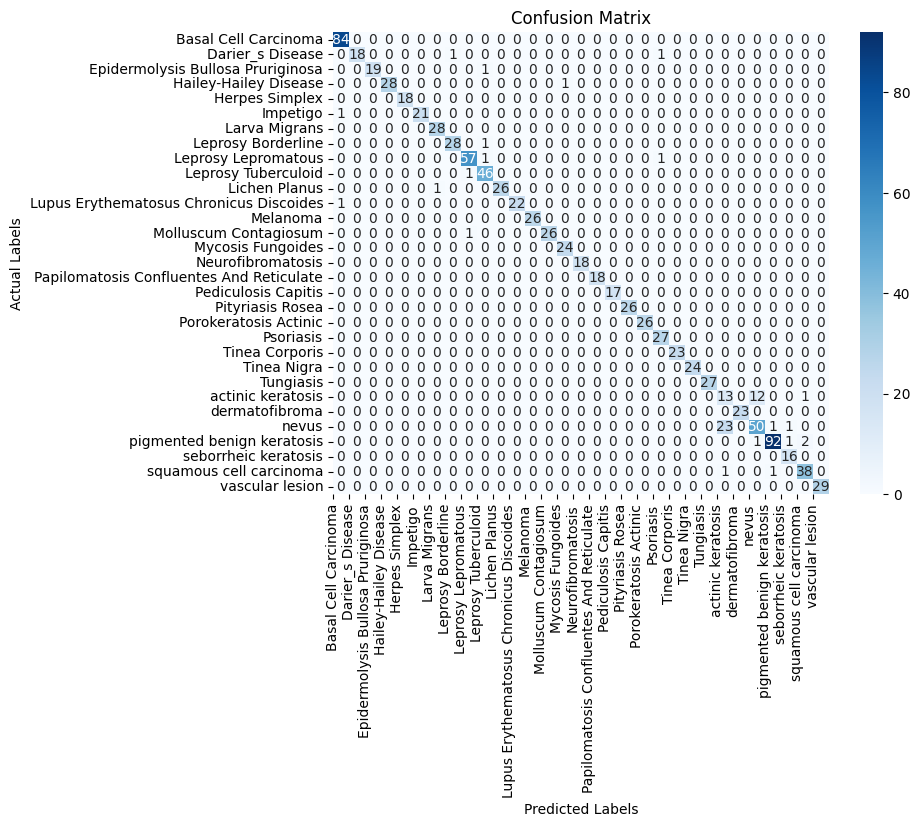

Classification Report:
                                           precision    recall  f1-score   support

                    Basal Cell Carcinoma     0.9767    1.0000    0.9882        84
                        Darier_s Disease     1.0000    0.9000    0.9474        20
       Epidermolysis Bullosa Pruriginosa     1.0000    0.9500    0.9744        20
                   Hailey-Hailey Disease     1.0000    0.9655    0.9825        29
                          Herpes Simplex     1.0000    1.0000    1.0000        18
                                Impetigo     1.0000    0.9545    0.9767        22
                           Larva Migrans     0.9655    1.0000    0.9825        28
                      Leprosy Borderline     0.9655    0.9655    0.9655        29
                     Leprosy Lepromatous     0.9661    0.9661    0.9661        59
                     Leprosy Tuberculoid     0.9388    0.9787    0.9583        47
                           Lichen Planus     1.0000    0.9630    0.9811  

In [22]:

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms
# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
class_names = ['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Plot confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Calculate and print classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names,digits=4)
print("Classification Report:\n", report)